# Getting features from NYC PLUTO

In this notebook, we will get and clean the NYC PLUTO Data. First, we extract relevant features from the NYC Pluto datasets. Specific features to be extracted include:
- Residential Units (sum of residential units in all buildings on the tax lot)
- Assessed Total Value (actual assessed total value for FY2015)
- Year Built (year construction of the building was completed)
- Year Altered 1 (if only one alteration then the year of the most recent alteration; otherwise the year of the second most recent alteration)
- Year Altered 2 (if more than one alteration then the year of the most recent alteration otherwise blank).
- Borough, Tax Block and Lat (BBL)
- Census Tract 2 (2010 census tract)

In [26]:
import pandas as pd
import re

### Read data in from downloaded csv file

def read_in_pluto_data():
    boroughs = {'bronx':'BX.csv', 'brooklyn':'BK.csv', 'Manhattan':'Mn.csv', 'Queens':'QN.csv', "Staten_island":'SI.csv'}
    frames = []
    for borough in boroughs.keys():
        df_name = borough + '_pluto'
        file_path = 'data/nyc_pluto_15v1/' + boroughs[borough]
        df_name = pd.read_csv(file_path)
        df_name = df_name[['UnitsRes','AssessTot','YearBuilt','YearAlter1','YearAlter2','BBL', 'Borough', 'Tract2010']]
        df_name = df_name[(df_name['UnitsRes'] != 0)]
        frames.append(df_name)
    result = pd.concat(frames, ignore_index=True)
    return result

pluto_dat = read_in_pluto_data()

In [27]:
pluto_dat.head(6)

,UnitsRes,AssessTot,YearBuilt,YearAlter1,YearAlter2,BBL,Borough,Tract2010
0,8,104219,1920,2009,0,2022600018,BX,19
1,8,25876,1920,0,0,2022610037,BX,19
2,12,347400,1925,0,0,2022610045,BX,19
3,1255,23375700,1956,0,0,2022630019,BX,25
4,2,26820,2000,0,0,2022630065,BX,25
5,2,26820,2000,0,0,2022630066,BX,25


Now to process the data, we'll:
- Pad the Tract2010 so it's in the format dddd.dd
- Construct two new features:
  - Year of last alteration, defined as $\max\{YearAlter1, YearAlter2\}$.
  - Avg_value_per_res_unit, defined as total assessed value per residential unit (constructed as $AssessTot/UnitRes$)
- Drop any rows with missing values

In [28]:
def proc_tract(val):
    val = str(val)
    split_val = re.split('\.',val)
    try:
        decimal = split_val[1].ljust(2, '0')
    except:
        decimal = '00'
    integer = split_val[0].zfill(4)
    new_code = integer + decimal
    return new_code

In [22]:
boroughs = 
pluto_dat['Tract2010'] = pluto_dat['Tract2010'].map(proc_tract)
pluto_dat['YearLastAlter'] = pluto_dat[['YearAlter1','YearAlter2']].max(axis=1)
pluto_dat = pluto_dat.drop(['YearAlter1','YearAlter2'],axis=1)
pluto_dat['Avg_value_per_res_unit'] = pluto_dat['AssessTot']/pluto_dat['UnitsRes']
pluto_dat.shape

(760834, 7)

In [23]:
pluto_dat = pluto_dat[~(pluto_dat.isnull().any(axis=1))]
pluto_dat.shape

(760833, 7)

In [24]:
pluto_dat.head(6)

,UnitsRes,AssessTot,YearBuilt,BBL,Tract2010,YearLastAlter,Avg_value_per_res_unit
0,8,104219,1920,2022600018,001900,2009,13027.375000
1,8,25876,1920,2022610037,001900,0,3234.500000
2,12,347400,1925,2022610045,001900,0,28950.000000
3,1255,23375700,1956,2022630019,002500,0,18626.055777
4,2,26820,2000,2022630065,002500,0,13410.000000
5,2,26820,2000,2022630066,002500,0,13410.000000


Finally, to start getting a sense of the marginal feature distributions, here are some histograms.

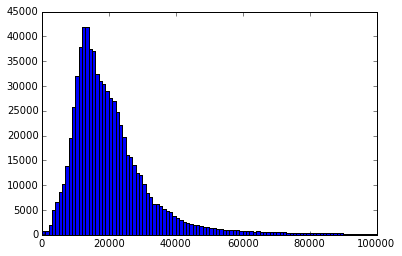

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline

val_per_unit = plt.hist(pluto_dat['Avg_value_per_res_unit'], bins=100, range=(0,10**5))
plt.show(val_per_unit)

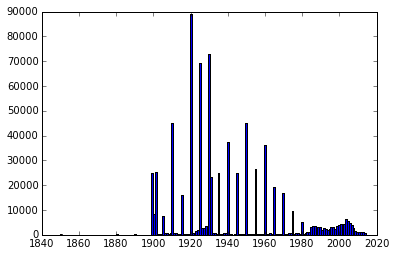

In [68]:
year_built = plt.hist(pluto_dat['YearBuilt'], bins=len(range(1850,2016)), range=(1850,2015))
plt.show(year_built)

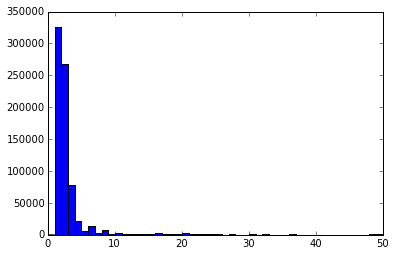

In [69]:
UnitsRes_hist = plt.hist(pluto_dat['UnitsRes'], bins=50, range=(0,50))
plt.show(UnitsRes_hist)